In [14]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
import numpy as np
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit import transpile
from numpy import pi
from qiskit_aer.noise import NoiseModel, QuantumError, depolarizing_error
from qiskit.result import marginal_counts
from qiskit.quantum_info import Operator, partial_trace, DensityMatrix
from functools import reduce
import matplotlib.pyplot as plt
import sympy as sp
qreg = QuantumRegister(4, 'q')
tmp = QuantumCircuit(qreg)

tmp.ry(pi/2,qreg[3])
tmp.rx(pi,qreg[3])
tmp.ry(-pi/2, qreg[2])
tmp.cz(qreg[0], qreg[2])
tmp.cz(qreg[1],qreg[2])
tmp.cz(qreg[3],qreg[2])
tmp.ry(pi/2, qreg[2])
tmp.ry(-pi/2, qreg[1])
tmp.cz(qreg[3],qreg[1])
tmp.ry(pi/2, qreg[1])
tmp.ry(-pi/2, qreg[0])
tmp.cz(qreg[3],qreg[0])
tmp.ry(pi/2, qreg[0])

Encoder = tmp.to_gate(label='[4,2,2] Encoder')
qreg = QuantumRegister(4, 'q')
ancilla = QuantumRegister(2, 'ancilla')
tmp = QuantumCircuit(qreg, ancilla)

tmp.ry(-pi/2, ancilla[0])
for i in range(4):
    tmp.cz(qreg[i],ancilla[0])
tmp.ry(pi/2, ancilla[0])

tmp.ry(pi/2,qreg)
tmp.rx(pi,qreg)

tmp.ry(-pi/2, ancilla[1])
for i in range(4):
    tmp.cz(qreg[i],ancilla[1])
tmp.ry(pi/2, ancilla[1])

Syndrom = tmp.to_gate(label='[4,2,2] Syndrom')
qreg = QuantumRegister(4, 'q')
tmp = QuantumCircuit(qreg)
tmp.ry(-pi/2,qreg[3])
tmp.rx(pi,qreg)
tmp.cz(qreg[3],qreg[0])
tmp.ry(pi/2, qreg[0])
tmp.cz(qreg[3],qreg[1])
tmp.ry(pi/2, qreg[1])
tmp.cz(qreg[3],qreg[2])
tmp.cz(qreg[1],qreg[2])
tmp.cz(qreg[0],qreg[2])
tmp.ry(pi/2, qreg[2])

tmp.ry(pi/2,qreg[3])
tmp.rx(pi,qreg[3])

Decoder = tmp.to_gate(label='[4,2,2] Decoder')
P0 = np.array([[1, 0], [0, 0]], dtype=complex)
P1 = np.array([[0, 0], [0, 1]], dtype=complex)
I = np.eye(2, dtype=complex)
M_I = reduce(np.kron, [I,I,I,I,P0,P0])
M_X = reduce(np.kron, [I,I,I,I,P0,P1])
M_Z = reduce(np.kron, [I,I,I,I,P1,P0])
M_XZ = reduce(np.kron, [I,I,I,I,P1,P1])

my_dict = {
    'I': M_I,
    'X': M_X,
    'Z': M_Z,
    'XZ': M_XZ
}

def fidelity(rho, state, index_arr, key):
    M = my_dict[key]
    rho_new = M@rho@M.conj().T
    trace = np.round(np.real_if_close(np.trace(rho_new)),3)
    if trace != 0:
        rho_new /= trace
    rho_new = DensityMatrix(rho_new)

    rho_new = partial_trace(rho_new, [0,1])

    qreg = QuantumRegister(4, 'q')
    qcirc = QuantumCircuit(qreg)
    
    for i in range(len(qreg)):
        if len(index_arr) < 2 and i in index_arr:
            if key == 'X':
                qcirc.x(3-i)
            if key == 'Z':
                qcirc.z(3-i)
            if key == 'XZ':
                qcirc.x(3-i)
                qcirc.z(3-i)

    qcirc.h(qreg)

    ##### decoder 
    qcirc.cx(qreg[3],qreg[0])
    qcirc.cx(qreg[3],qreg[1])
    qcirc.cx(qreg[3],qreg[2])
    qcirc.cx(qreg[1],qreg[2])
    qcirc.cx(qreg[0],qreg[2])
    qcirc.h(qreg[3])

    rho_np = rho_new.evolve(qcirc)
    rho_np = rho_np.data

    v0 = np.array([1,0], dtype=complex)
    init_statevector = reduce(np.kron, [v0, v0,state])
    F = init_statevector.conj().T @ rho_np @ init_statevector
    F = np.real_if_close(F)
    F = np.round(F.item(),3)
    return F, trace

def average_fidelity(state, index_arr=[]):
    qreg = QuantumRegister(4, 'q')
    ancilla = QuantumRegister(2, 'ancilla')
    qcirc = QuantumCircuit(qreg, ancilla)
    qcirc.initialize(state, [0,1])
    qcirc.initialize([1, 0], 2)
    qcirc.initialize([1, 0], 3)

    ##### encoder
    qcirc.h(qreg[3])
    qcirc.cx(qreg[0],qreg[2])
    qcirc.cx(qreg[1],qreg[2])
    qcirc.cx(qreg[3],qreg[2])
    qcirc.cx(qreg[3],qreg[1])
    qcirc.cx(qreg[3],qreg[0])

    for i in range(len(qreg)):
        if i in index_arr:
            qcirc.reset(i)

    for i in range(4):
        qcirc.cx(qreg[i],ancilla[0])

    qcirc.h(qreg)

    for i in range(4):
        qcirc.cx(qreg[i],ancilla[1])

    qcirc.save_density_matrix(qubits=[5,4,3,2,1,0], label='rho')

    simulator = AerSimulator(method='density_matrix')
    tqc = transpile(qcirc, simulator)
    result = simulator.run(tqc).result()
    data = result.data()
    rho_array = data['rho']
    rho = rho_array.data

    prob = 0
    for key in my_dict.keys():
        p, f = fidelity(rho, state, index_arr, key)
        prob += p*f
    return prob

def coefficient_calc(state):
    coeffs = [0,0,0,0]

    coeffs[0] = average_fidelity(state, [0,1,2,3])
    for i in range(4):
        coeffs[1] += 1/4 * average_fidelity(state, [i])
        coeffs[2] += 1/4 * average_fidelity(state, list(filter(lambda x: x != i, [0,1,2,3])))
        for j in range(i, 4):
            coeffs[3] += 1/6 * average_fidelity(state, list(filter(lambda x: x != i and x != j, [0,1,2,3])))
    return coeffs

def logic_phys_correlation(p, coeffs):
  prob = p**4 * coeffs[0] + 4* p * (1-p)**3 * coeffs[1] + 4*p**3 * (1-p) * coeffs[2] + 6*p**2 * (1-p)**2 * coeffs[3] + (1-p)**4
  return prob

def random_two_qubit_state(seed=None):
    if seed is not None:
        np.random.seed(seed)
    real = np.random.randn(4)
    imag = np.random.randn(4)
    psi = real + 1j * imag
    psi /= np.linalg.norm(psi)
    return psi
    
def find_threshold(coeffs):
    x = sp.Symbol('x')
    f = x**4 * coeffs[0] + 4*x * (1-x)**3 * coeffs[1] + 4*x**3 * (1-x) * coeffs[2] + 6*x**2 * (1-x)**2 * coeffs[3] + (1-x)**4
    g = 1 - x
    solutions = sp.solve(sp.Eq(f, g), x)
    real_solutions = []
    for s in solutions:
        s_val = complex(s.evalf())
        if abs(s_val.imag) < 1e-10 and 0 < s_val.real <= 1:
            real_solutions.append(round(s_val.real, 12))    
    if not real_solutions:
        real_solutions = [1]
    return min(real_solutions)    
    
def params_to_state(x):
    theta1, theta2, theta3 = x[0], x[1], x[2]
    phi1, phi2, phi3       = x[3], x[4], x[5]

    a0 = np.cos(theta1)
    s1 = np.sin(theta1)
    a1 = s1 * np.cos(theta2) * np.exp(1j * phi1)
    s2 = np.sin(theta2)
    a2 = s1 * s2 * np.cos(theta3) * np.exp(1j * phi2)
    a3 = s1 * s2 * np.sin(theta3) * np.exp(1j * phi3)

    psi = np.array([a0, a1, a2, a3], dtype=complex)
    psi = psi / np.linalg.norm(psi)
    return psi

def func(x): 
    state = params_to_state(x) 
    coeffs = coefficient_calc(state)
    return find_threshold(coeffs)

In [16]:
from scipy.optimize import differential_evolution, minimize
import numpy as np

history = []
values = []

def safe_func(x):
    v = func(np.array(x))
    return float(v[0]) if isinstance(v, (list, np.ndarray)) else float(v)

def callback(xk):
    val = safe_func(xk)
    history.append(val)

def de_callback(xk, convergence):
    val = safe_func(xk)
    values.append(val)
    return False

# границы: theta1..3 ∈ [0, pi/2], phi1..3 ∈ [0, 2*pi]
bounds = [(0, np.pi/2)]*3 + [(0, 2*np.pi)]*3

# глобальная оптимизация
res_de = differential_evolution(safe_func, bounds, callback=de_callback, maxiter=5, popsize=15, polish=False)
# локальная доработка от найденной точки
res_local = minimize(safe_func, res_de.x, method='Nelder-Mead', callback=callback, options={'maxiter':5})
best_x, best_val = (res_local.x, res_local.fun) if res_local.fun < res_de.fun else (res_de.x, res_de.fun)

print("best =", best_val)
print("x =", best_x)

if len(history) > 1:
    diff = history[-1] - history[-2]
    print("Δ(last - prev) =", diff)

if len(values) > 1:
    print("Δ(last - prev) =", values[-1] - values[-2])


best = 0.241129777588
x = [1.58986211 0.98920264 0.85796139 3.15093636 5.74152751 2.38886592]
Δ(last - prev) = 0.0
Δ(last - prev) = 0.0


In [51]:
def generate_graph(psi=random_two_qubit_state(),show_state = False):
    if show_state:
        print(psi)
    state = np.array(psi, dtype=complex)
    coeffs = coefficient_calc(state)
    phys_prob = np.arange(0, 1, 0.01)
    log_prob0 = []
    log_prob1 = []
    log_prob2 = []
    for p in phys_prob:
        log_prob0.append(1-p)
        log_prob1.append(logic_phys_correlation(p, coeffs))
        log_prob2.append( (1-p)**4 + 4*p*(1-p)**3 )
    plt.plot(phys_prob, log_prob0, label = 'no correction', color='g')
    plt.plot(phys_prob, log_prob1, label = 'using [4,2,2] correction', color='y')
    plt.plot(phys_prob, log_prob2, label = '$(1-p)^4 + 4p(1-p)^3$',linestyle='dotted', color='r')
    threshold = find_threshold(coeffs)
    if threshold < 1:
        plt.axvline(x=threshold, color='gray', linestyle='--', linewidth=2, label='threshold p =' + str(round(threshold,3)))
    plt.xlabel('p (probability of physical error)')
    plt.ylabel('p_L (probability of success)')
    plt.legend()
    plt.xlim((0,1))
    plt.ylim((0,1))
    plt.grid()
    plt.show()

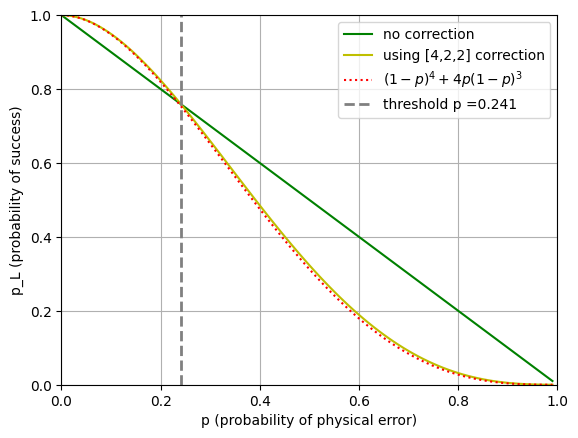

In [52]:
state = params_to_state(best_x)
generate_graph(psi=state)

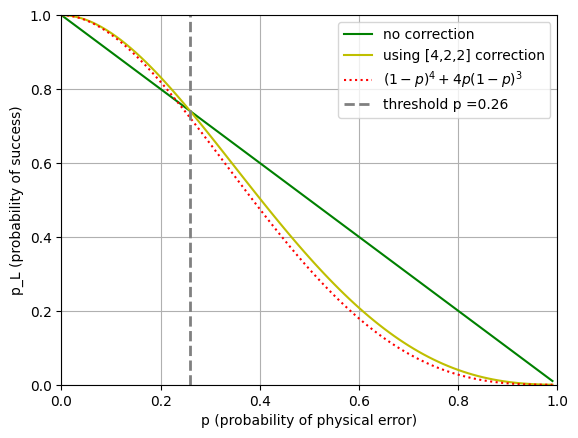

In [57]:
state1 = [0,1]
state2 = [1,0]
v1 = np.array(state1, dtype=complex)
v2 = np.array(state2, dtype=complex)
stata = np.array(np.kron(v2,v1), dtype=complex)

generate_graph(psi=stata)

In [58]:
print(state)

[-0.01906463+0.j         -0.54923248-0.00513202j  0.468151  -0.28167959j
 -0.46126319+0.43206644j]
